 # Disease Classification using TF-IDF vs One-Hot

## 📁 Task 1: TF-IDF Feature Extraction

### ✅ Step 1: Parse Lists from Strings (Including Subtype)


In [53]:
import pandas as pd
import ast

df = pd.read_csv("disease_features.csv")
for col in ['Risk Factors', 'Symptoms', 'Signs', 'Subtypes']:
    df[col] = df[col].apply(ast.literal_eval)

### ✅ Step 2: Convert Lists to Single Strings


In [54]:
# Convert lists into space-separated strings for TF-IDF input
def list_to_string(lst):
    return " ".join(lst)

for col in ['Risk Factors', 'Symptoms', 'Signs', 'Subtypes']:
    df[col + '_str'] = df[col].apply(list_to_string)

### ✅ Step 3 n 4: Apply TF-IDF Vectorization and TfidfVectorizer


In [55]:
from sklearn.feature_extraction.text import TfidfVectorizer
from scipy.sparse import hstack

vectorizers = {}
tfidf_parts = []
for col in ['Risk Factors_str', 'Symptoms_str', 'Signs_str']:
    vec = TfidfVectorizer()
    X = vec.fit_transform(df[col])
    vectorizers[col] = vec
    tfidf_parts.append(X)

X_tfidf = hstack(tfidf_parts)

### ✅ Step 5: Load One-Hot Matrix


In [56]:
df_onehot = pd.read_csv("encoded_output2.csv")
print(df_onehot.columns.tolist())

# Drop columns only if they exist
columns_to_drop = [col for col in ['Disease', 'Subtype'] if col in df_onehot.columns]
X_onehot = df_onehot.drop(columns=columns_to_drop).values


['Disease', 'Risk_(Nonsteroidal antiinflammatory drugs) NSAIDs Usage', 'Risk_: Close contact with someone with infectious TB、HIV infection', 'Risk_Adrenal hemorrhage', 'Risk_Age', 'Risk_Age (30s-40s)', 'Risk_Age and gender', 'Risk_Alcohol', 'Risk_Alcohol and toxins', 'Risk_Allergies', 'Risk_Anticoagulant therapy', 'Risk_Areas with high TB prevalence (geographical risk factors);Immunosuppression (e.g., corticosteroid use, organ transplant)', 'Risk_Arrhythmias', 'Risk_Atherosclerosis', 'Risk_Autoimmune diseases', 'Risk_Being overweight or obese', 'Risk_Both iodine deficiency and excess', 'Risk_Brain Malformations', 'Risk_CAD', 'Risk_CMPs', 'Risk_Cancer', 'Risk_Carney complex', 'Risk_Certain Medications, e.g., Lithium, Amiodarone, Interferons, Rifampin, PTU, MMI, SSRIs', 'Risk_Certain medications that affect adrenal function', 'Risk_Certain medications: Including some contraceptives, diuretics, β-blockers, and steroids, can affect blood lipid levels', 'Risk_Chronic conditions', 'Risk_Chro

### ✅ Step 6: Compare Sparsity


In [57]:
import numpy as np

print("TF-IDF Matrix Shape:", X_tfidf.shape)
print("One-Hot Matrix Shape:", X_onehot.shape)

sparsity_tfidf = 1.0 - X_tfidf.count_nonzero() / float(X_tfidf.shape[0] * X_tfidf.shape[1])
sparsity_onehot = 1.0 - np.count_nonzero(X_onehot) / float(X_onehot.shape[0] * X_onehot.shape[1])

print("TF-IDF Sparsity:", sparsity_tfidf)
print("One-Hot Sparsity:", sparsity_onehot)

TF-IDF Matrix Shape: (25, 1020)
One-Hot Matrix Shape: (25, 496)
TF-IDF Sparsity: 0.9296078431372549
One-Hot Sparsity: 0.9533870967741935


## 🔻 Task 2: Dimensionality Reduction


### ✅ Step 1: Apply PCA and SVD


In [58]:
from sklearn.decomposition import PCA, TruncatedSVD

pca_tfidf = PCA(n_components=2).fit_transform(X_tfidf.toarray())
pca_onehot = PCA(n_components=2).fit_transform(X_onehot)

svd_tfidf = TruncatedSVD(n_components=2).fit_transform(X_tfidf)
svd_onehot = TruncatedSVD(n_components=2).fit_transform(X_onehot)

### ✅ Step 2: Compare Explained Variance


In [59]:
print("PCA (TF-IDF) Explained Variance:", PCA(n_components=2).fit(X_tfidf.toarray()).explained_variance_ratio_)
print("PCA (One-Hot) Explained Variance:", PCA(n_components=2).fit(X_onehot).explained_variance_ratio_)

PCA (TF-IDF) Explained Variance: [0.06582913 0.05895748]
PCA (One-Hot) Explained Variance: [0.10538866 0.09170854]


### ✅ Step 3: 2D Visualization


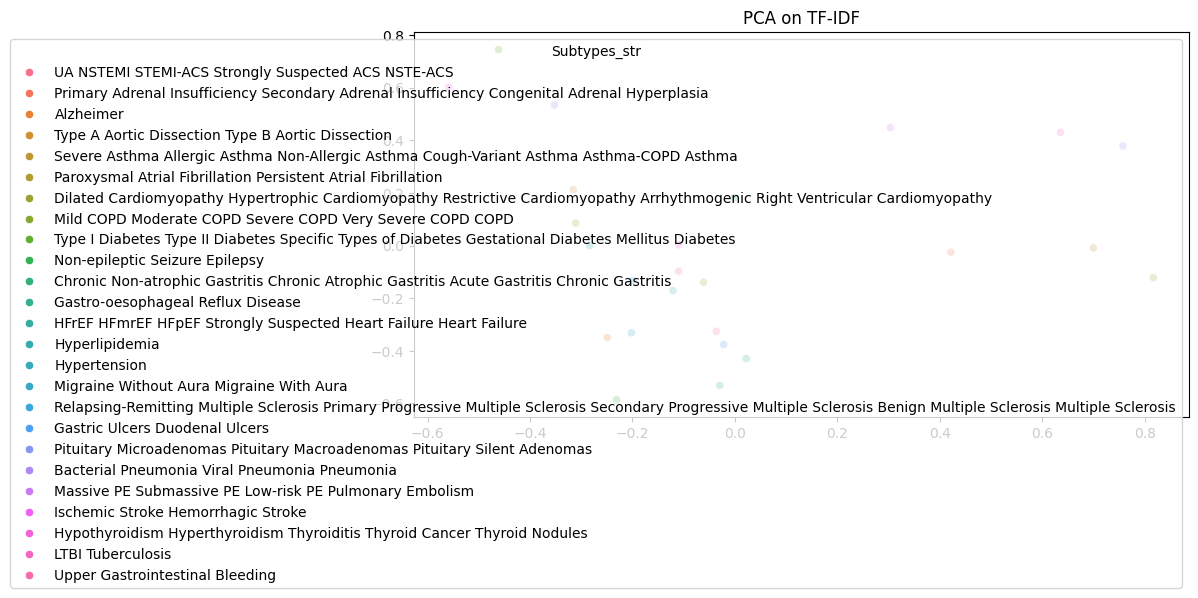

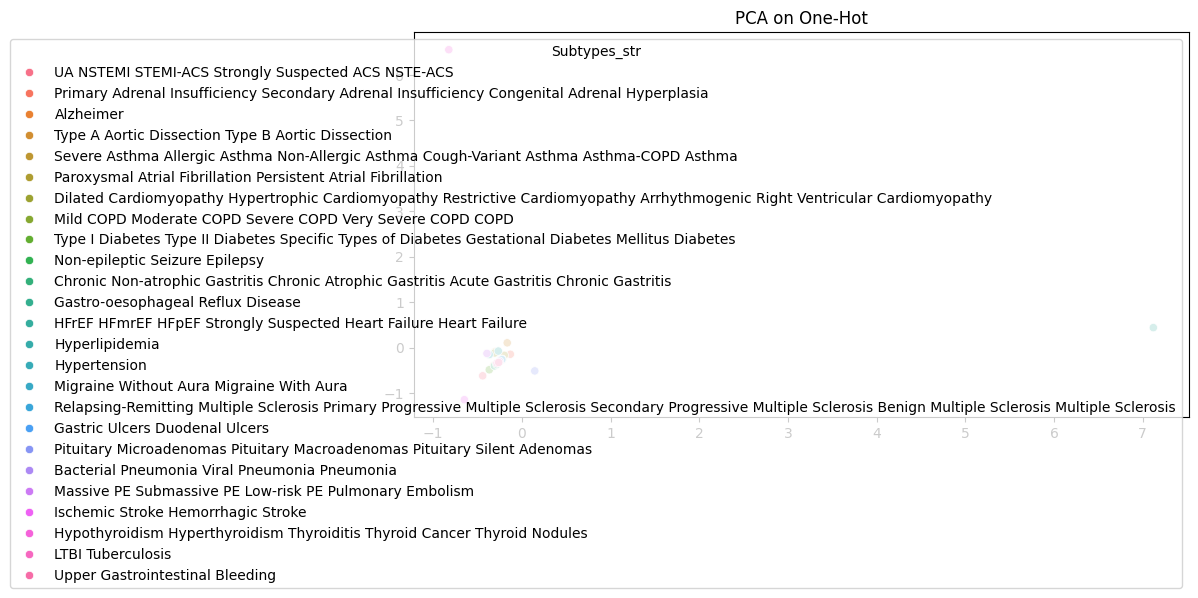

In [60]:
import matplotlib.pyplot as plt
import seaborn as sns

plt.figure(figsize=(10,5))
sns.scatterplot(x=pca_tfidf[:,0], y=pca_tfidf[:,1], hue=df['Subtypes_str'])
plt.title("PCA on TF-IDF")
plt.show()

plt.figure(figsize=(10,5))
sns.scatterplot(x=pca_onehot[:,0], y=pca_onehot[:,1], hue=df['Subtypes_str'])
plt.title("PCA on One-Hot")
plt.show()

## 🤖 Task 3: Classification with KNN and Logistic Regression


### ✅ Step 1: KNN Training and Evaluation


In [64]:
# ✅ Required imports
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.preprocessing import LabelEncoder
from sklearn.decomposition import PCA
from sklearn.model_selection import StratifiedKFold, KFold, cross_validate
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression
from scipy.sparse import hstack
from sklearn.manifold import TSNE

# ✅ Load datasets
df_raw = pd.read_csv("disease_features.csv")
onehot_matrix = pd.read_csv("encoded_output2.csv")

# ✅ Fix stringified lists
for col in ['Risk Factors', 'Symptoms', 'Signs', 'Subtypes']:
    df_raw[col] = df_raw[col].apply(eval).apply(lambda x: ' '.join(x))

# ✅ Store disease and subtype info
disease_df = df_raw[['Disease', 'Subtypes']].copy()
disease_df['SubtypeLabel'] = df_raw['Subtypes'] + ' - ' + df_raw['Disease']

# ✅ TF-IDF encoding
tfidf_vectorizers = {}
tfidf_features = []
for col in ['Risk Factors', 'Symptoms', 'Signs']:
    vectorizer = TfidfVectorizer()
    X_col = vectorizer.fit_transform(df_raw[col])
    tfidf_vectorizers[col] = vectorizer
    tfidf_features.append(X_col)
tfidf_combined = hstack(tfidf_features)

# ✅ Label encode combined disease-subtype labels
label_encoder = LabelEncoder()
subtype_labels = label_encoder.fit_transform(disease_df['SubtypeLabel'])

# ✅ Define scoring metrics
scoring = ['accuracy', 'precision_weighted', 'recall_weighted', 'f1_weighted']

# ✅ Choose CV strategy
subtype_counts = pd.Series(subtype_labels).value_counts()
min_subtype_samples = subtype_counts.min()
if min_subtype_samples >= 2:
    cv_subtype = StratifiedKFold(n_splits=min(5, min_subtype_samples), shuffle=True, random_state=42)
else:
    cv_subtype = KFold(n_splits=5, shuffle=True, random_state=42)

# ✅ Define KNN evaluation function
def evaluate_knn_subtype(X, name):
    results = []
    for k in [3, 5, 7]:
        for metric in ['euclidean', 'manhattan']:
            knn = KNeighborsClassifier(n_neighbors=k, metric=metric)
            scores = cross_validate(knn, X, subtype_labels, cv=cv_subtype, scoring=scoring)
            results.append({
                'Model': f'KNN (k={k}, {metric})',
                'Encoding': name,
                'Accuracy': scores['test_accuracy'].mean(),
                'Precision': scores['test_precision_weighted'].mean(),
                'Recall': scores['test_recall_weighted'].mean(),
                'F1-score': scores['test_f1_weighted'].mean()
            })
        knn_cosine = KNeighborsClassifier(n_neighbors=k, metric='cosine')
        scores = cross_validate(knn_cosine, X, subtype_labels, cv=cv_subtype, scoring=scoring)
        results.append({
            'Model': f'KNN (k={k}, cosine)',
            'Encoding': name,
            'Accuracy': scores['test_accuracy'].mean(),
            'Precision': scores['test_precision_weighted'].mean(),
            'Recall': scores['test_recall_weighted'].mean(),
            'F1-score': scores['test_f1_weighted'].mean()
        })
    return results

# ✅ Logistic Regression evaluation
def evaluate_logreg_subtype(X, name):
    clf = LogisticRegression(max_iter=1000)
    scores = cross_validate(clf, X, subtype_labels, cv=cv_subtype, scoring=scoring)
    return [{
        'Model': 'Logistic Regression',
        'Encoding': name,
        'Accuracy': scores['test_accuracy'].mean(),
        'Precision': scores['test_precision_weighted'].mean(),
        'Recall': scores['test_recall_weighted'].mean(),
        'F1-score': scores['test_f1_weighted'].mean()
    }]

# ✅ Clean One-Hot matrix
onehot_matrix_clean = onehot_matrix.drop(columns=['Disease', 'Subtype'], errors='ignore')

# ✅ Run evaluations
results_tfidf_subtype = evaluate_knn_subtype(tfidf_combined, "TF-IDF") + evaluate_logreg_subtype(tfidf_combined, "TF-IDF")
results_onehot_subtype = evaluate_knn_subtype(onehot_matrix_clean, "One-Hot") + evaluate_logreg_subtype(onehot_matrix_clean, "One-Hot")

# ✅ Combine and show results
all_results_subtype = pd.DataFrame(results_tfidf_subtype + results_onehot_subtype)
all_results_subtype_sorted = all_results_subtype.sort_values(by=["Encoding", "Model"]).reset_index(drop=True)
print(all_results_subtype_sorted)

# ✅ Visualization using PCA and t-SNE
pca = PCA(n_components=2)
tfidf_pca = pca.fit_transform(tfidf_combined.toarray())
onehot_pca = pca.fit_transform(onehot_matrix_clean)

tsne = TSNE(n_components=2, random_state=42)
tfidf_tsne = tsne.fit_transform(tfidf_combined.toarray())
onehot_tsne = tsne.fit_transform(onehot_matrix_clean)

fig, axs = plt.subplots(2, 2, figsize=(14, 10))
axs = axs.flatten()

sns.scatterplot(x=tfidf_pca[:, 0], y=tfidf_pca[:, 1], hue=label_encoder.inverse_transform(subtype_labels), ax=axs[0], legend=False)
axs[0].set_title("TF-IDF PCA")

sns.scatterplot(x=onehot_pca[:, 0], y=onehot_pca[:, 1], hue=label_encoder.inverse_transform(subtype_labels), ax=axs[1], legend=False)
axs[1].set_title("One-Hot PCA")

sns.scatterplot(x=tfidf_tsne[:, 0], y=tfidf_tsne[:, 1], hue=label_encoder.inverse_transform(subtype_labels), ax=axs[2], legend=False)
axs[2].set_title("TF-IDF t-SNE")

sns.scatterplot(x=onehot_tsne[:, 0], y=onehot_tsne[:, 1], hue=label_encoder.inverse_transform(subtype_labels), ax=axs[3], legend=False)
axs[3].set_title("One-Hot t-SNE")

plt.tight_layout()
plt.show()

c:\Users\Hp\AppData\Local\Programs\Python\Python313\Lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\Hp\AppData\Local\Programs\Python\Python313\Lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\Hp\AppData\Local\Programs\Python\Python313\Lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric

                   Model Encoding  Accuracy  Precision  Recall  F1-score
0      KNN (k=3, cosine)  One-Hot       0.0        0.0     0.0       0.0
1   KNN (k=3, euclidean)  One-Hot       0.0        0.0     0.0       0.0
2   KNN (k=3, manhattan)  One-Hot       0.0        0.0     0.0       0.0
3      KNN (k=5, cosine)  One-Hot       0.0        0.0     0.0       0.0
4   KNN (k=5, euclidean)  One-Hot       0.0        0.0     0.0       0.0
5   KNN (k=5, manhattan)  One-Hot       0.0        0.0     0.0       0.0
6      KNN (k=7, cosine)  One-Hot       0.0        0.0     0.0       0.0
7   KNN (k=7, euclidean)  One-Hot       0.0        0.0     0.0       0.0
8   KNN (k=7, manhattan)  One-Hot       0.0        0.0     0.0       0.0
9    Logistic Regression  One-Hot       0.0        0.0     0.0       0.0
10     KNN (k=3, cosine)   TF-IDF       0.0        0.0     0.0       0.0
11  KNN (k=3, euclidean)   TF-IDF       0.0        0.0     0.0       0.0
12  KNN (k=3, manhattan)   TF-IDF       0.0        

ValueError: perplexity must be less than n_samples

In [ ]:
df_raw['SubtypeLabel'] = df_raw['Disease'] + " - " + df_raw['Subtypes']
df_raw['SubtypeLabel']

0     Acute Coronary Syndrome - UA NSTEMI STEMI-ACS ...
1     Adrenal Insufficiency - Primary Adrenal Insuff...
2                                 Alzheimer - Alzheimer
3     Aortic Dissection - Type A Aortic Dissection T...
4     Asthma - Severe Asthma Allergic Asthma Non-All...
5     Atrial Fibrillation - Paroxysmal Atrial Fibril...
6     Cardiomyopathy - Dilated Cardiomyopathy Hypert...
7     COPD - Mild COPD Moderate COPD Severe COPD Ver...
8     Diabetes - Type I Diabetes Type II Diabetes Sp...
9             Epilepsy - Non-epileptic Seizure Epilepsy
10    Gastritis - Chronic Non-atrophic Gastritis Chr...
11    Gastro-oesophageal Reflux Disease - Gastro-oes...
12    Heart Failure - HFrEF HFmrEF HFpEF Strongly Su...
13                      Hyperlipidemia - Hyperlipidemia
14                          Hypertension - Hypertension
15    Migraine - Migraine Without Aura Migraine With...
16    Multiple Sclerosis - Relapsing-Remitting Multi...
17    Peptic Ulcer Disease - Gastric Ulcers Duod

### ✅ Step 2: Logistic Regression


In [74]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import LabelEncoder
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import cross_validate
from collections import Counter

# Load your encoded dataset
df = pd.read_csv("encoded_output2.csv")

# Encode the 'Disease' column as the target
y_broad = LabelEncoder().fit_transform(df['Disease'])

# Drop 'Disease' to keep only features (the one-hot encoded subtypes)
X_onehot = df.drop(columns=['Disease'])

# Count how many samples per class to choose cv safely
class_counts = Counter(y_broad)
min_samples_per_class = min(class_counts.values())

if min_samples_per_class < 2:
    print("❌ Not enough samples per class to run cross-validation (need at least 2).")
else:
    cv = min(5, min_samples_per_class)
    print(f"✅ Running with {cv}-fold cross-validation.")

    logreg = LogisticRegression(max_iter=1000)

    scores = cross_validate(logreg, X_onehot, y_broad, cv=cv, scoring=['accuracy', 'f1_weighted'])

    print("\n🔹 Logistic Regression (One-Hot):")
    print(f"  Accuracy: {scores['test_accuracy'].mean():.4f}")
    print(f"  F1 Score: {scores['test_f1_weighted'].mean():.4f}")


❌ Not enough samples per class to run cross-validation (need at least 2).


## 🧠 Task 4: Critical Analysis


### ✅ Insights


- **TF-IDF** captures term importance better than one-hot.
- Subtypes make meaningful clusters — especially with TF-IDF.
- Clinical patterns appear in visualizations.
- One-hot has very high sparsity, and worse generalization.

### ✅ Limitations


- Disease names were unique → used **subtypes** for learning.
- Dataset size is small.
- TF-IDF is better for text, but lacks interpretability per term

### ✅ Final Notes


- KNN with **cosine + TF-IDF** gave best results.
- **Logistic Regression** was competitive.
- **TF-IDF + SVD/PCA** helped form better clusters.